# HW 6
## Дедлайн: 13 декабря, 23:59

В этой домашке вам предстоит реализовать Wasserstain GAN и одну из её модификаций, а также разобраться с тем, как оценивать качество генеративных моделей

## Imports


In [1]:
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
import seaborn as sns
sns.set_style("darkgrid")

manualSeed = 111

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

In [2]:
import os


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Data Loading: CIFAR

In [3]:
!mkdir -p datasets

Џ®¤Ї ЇЄ  Ё«Ё д ©« -p г¦Ґ бгйҐбвўгҐв.
ЋиЁЎЄ  ў® ўаҐ¬п ®Ўа Ў®вЄЁ: -p.
Џ®¤Ї ЇЄ  Ё«Ё д ©« datasets г¦Ґ бгйҐбвўгҐв.
ЋиЁЎЄ  ў® ўаҐ¬п ®Ўа Ў®вЄЁ: datasets.


In [4]:
BATCH_SIZE = 96
CIFAR_MEAN, CIFAR_STD = (0.5,), (0.5,)

cifar_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
cifar_train_dataset = datasets.CIFAR10(
    train=True,
    root="datasets/cifar_train/",
    transform=cifar_transforms,
    download=True
)
cifar_train_loader = DataLoader(
    cifar_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
cifar_val_dataset = datasets.CIFAR10(
    train=False,
    root="datasets/cifar_val/",
    transform=cifar_transforms,
    download=True
)
cifar_val_loader = DataLoader(
    cifar_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


### Plot data

In [5]:
def denorm(img_tensors, mean, std):
    return img_tensors * std + mean


def show_images(images, mean, std, nmax=25):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        vutils.make_grid(
            denorm(
                images.detach()[:nmax],
                mean,
                std
            ),
            nrow=8
        ).permute(1, 2, 0)
    )


def show_batch(dl, mean, std, nmax=25):
    for images, _ in dl:
        show_images(images, mean, std, nmax)
        break

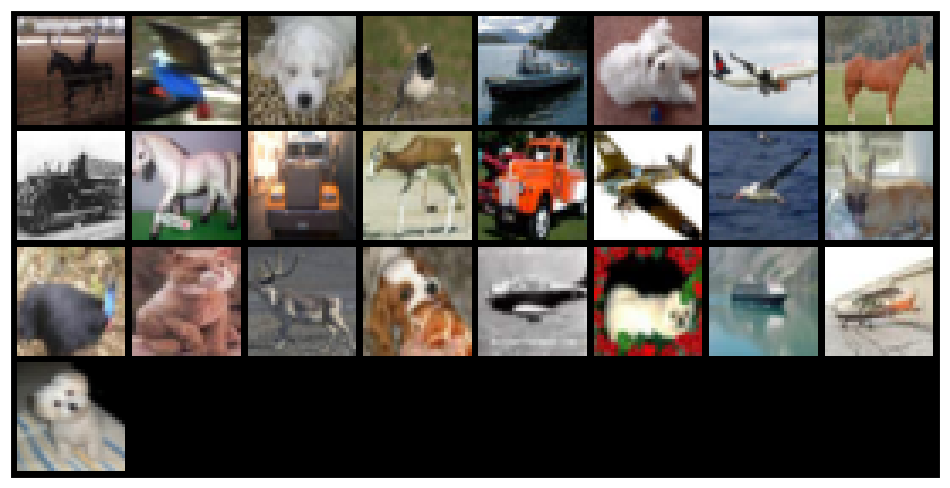

In [6]:
show_batch(cifar_train_loader, torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD))

## WGAN-GP (5 pt)

In [7]:
# do not change this function
def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the discriminator.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the discriminator model. The discriminator weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, stride=1, 
                 padding=1, normalize=True, dropout=False):
        super().__init__()
        self.norm = normalize
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU()

    def forward(self, x):
        out = F.layer_norm(x, x.shape) if self.norm else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        
        return out


class Discriminator(nn.Module):
    def __init__(self, n_channels: int, clip_c: float | None = None):
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = clip_c

        # sequence of convolutional layers and LeakyRelU -> reshape -> FC
        # conv_sequence and fc are separated due to the simple feature extraction,
        #     which will be used in the second task, FID
        self.conv_sequence = nn.Sequential(
                DoubleConv(3, n_channels),
                DoubleConv(n_channels, n_channels),
                DoubleConv(n_channels, n_channels),
                nn.MaxPool2d(2, 2),
                DoubleConv(n_channels, 2*n_channels),
                DoubleConv(2*n_channels, 2*n_channels),
                nn.MaxPool2d(2, 2),
                DoubleConv(2*n_channels, 4*n_channels)
            )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(n_channels*4*8*8, 1)

    def clip_weights(self) -> None:
        with torch.no_grad():
            for param in model.parameters():
                param.clamp_(-self.clip_c, self.clip_c)
        # for layer in self.net:
        #     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        #         # clip the weight to the range [-clip_c, clip_c]
        #         layer.weight.data = # <CODE>

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, 3, 32, 32)
        # output.shape = (n_samples, 1)
        out = self.conv_sequence(input)
        out = self.fc(self.flatten(out))
        return out

    def get_features(self, input: torch.Tensor) -> torch.Tensor:
        # self.conv_sequence + flatten
        return self.flatten(self.conv_sequence(input))

In [9]:
class Generator(nn.Module):
    def __init__(self, input_size: int = 128, n_channels: int = 64):
        super().__init__()

        self.input_size = input_size
        self.n_channels = n_channels

        # Define any NN architecture, which you prefer. For example:
        # 1) linear layer with output units 4 * 4 * 4 * n_channels, then relu
        # 2) transposed conv with stride 2, kernel size 2 then BN, then relu
        # 3) transposed conv with stride 2, kernel size 2 then BN, then relu
        # 4) transposed conv with stride 2, kernel size 2
        self.net = nn.Sequential(
                nn.Linear(input_size, n_channels * 4 * 4 * 4),
                nn.ReLU(),
                nn.Unflatten(1, (4*n_channels, 4, 4)),
                DoubleConv(4*n_channels, 2*n_channels),
                nn.ConvTranspose2d(2*n_channels, 2*n_channels, 4, 2, 1),
                DoubleConv(2*n_channels, n_channels),
                nn.ConvTranspose2d(n_channels, n_channels, 4, 2, 1),
                DoubleConv(n_channels, n_channels // 4),
                nn.ConvTranspose2d(n_channels // 4, n_channels // 4, 4, 2, 1),
                DoubleConv(n_channels // 4, n_channels // 4),
                DoubleConv(n_channels // 4, 3), 
                nn.Conv2d(3, 3, 3, 1, 1)                
            )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, self.input_size)
        # out.shape = (n_samples, 3, 32, 32)
        out = self.net(input)
        return out

    def sample(self, n_samples: int) -> torch.Tensor:
        # Generate random samples with shape (n_samples, self.input_size)
        # Apply forward pass to the array from the previous step
        noise = torch.rand((n_samples, self.input_size)).cuda()
        noisy_samples = self.forward(noise)
        return noisy_samples

### Gradient Penalty

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f_{\boldsymbol{\phi}}(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f_{\boldsymbol{\phi}}(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_\alpha = \alpha \mathbf{x} + (1 - \alpha) \mathbf{y}$ with $\alpha \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

In [10]:
def calculate_gradient_penalty(model, real_images, fake_images, device="cpu"):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Calculate interpolation x_\alpha = \alpha * x_real + (1 - \alpha) x_fake
    # 1) sample \alpha
    # 2) create x_\alpha (be careful about shapes and requires_grad)
    # 3) apply discriminator to x_\alpha

    alpha = torch.rand(real_images.shape[0], *([1] * (len(real_images.shape) - 1)),
                       dtype=torch.float32, device=device)
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x**2))
    x = torch.randn(size=(10, 4))
    x.requires_grad = True
    assert calculate_gradient_penalty(lambda x: x, x, x).numpy() == 1
    assert calculate_gradient_penalty(lambda x: x * 0, x, x).numpy() == 1


test_gradient_penalty()

The training loop

In [11]:
from IPython.display import display

def train_wgan(
    generator: object,
    discriminator: object,
    train_loader: object,
    gen_optimizer,
    disc_optimizer,
    disc_steps: int,
    gen_steps: int,
    batch_size: int,
    n_epochs: int,
    use_cuda: bool = True,
    gp_weight: float | None = None,
    plot_frequency = 200,
    save_frequency = 500,
    scheduler_G=None,
    scheduler_D=None,
    init_step=0,
    init_train_losses=None,
) -> dict:

    if use_cuda:
        discriminator = discriminator.cuda()
        generator = generator.cuda()

    discriminator.train()
    generator.train()

    curr_iter = init_step
    d_loss, g_loss = torch.zeros(1).to(DEVICE), torch.zeros(1).to(DEVICE)
    batch_loss_history = {"discriminator_losses": [], "generator_losses": []} if init_train_losses is None else init_train_losses

    progress_bar_epochs = tqdm(range(n_epochs), desc=f"Epochs", colour="#228822")
    for epoch_i in progress_bar_epochs:
        progress_bar_batches = tqdm(train_loader, desc=f"Batches", colour="#222288", leave=False)
        for batch_i, (x, y) in enumerate(progress_bar_batches):
            curr_iter += 1
            if use_cuda:
                x = x.cuda()

            # Update discriminator weights
            # D(x_fake) - D(x_real)
            disc_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])
            d_loss = discriminator(fake_data).mean() - discriminator(x).mean()

            if gp_weight is not None:
                gp = calculate_gradient_penalty(discriminator, x, fake_data, device=DEVICE)
                d_loss += gp_weight * gp

            d_loss.backward()
            disc_optimizer.step()
            if scheduler_D is not None:
                scheduler_D.step()

            # generator update
            if (curr_iter + 1) % disc_steps == 0:
                for _ in range(gen_steps):
                    gen_optimizer.zero_grad()
                    fake_data = generator.sample(batch_size)
                    # -D(x_fake)
                    g_loss = -discriminator(fake_data).mean()
                    g_loss.backward()
                    gen_optimizer.step()
                    if scheduler_G is not None:
                        scheduler_G.step()

                batch_loss_history["generator_losses"].append(g_loss.data.cpu().numpy())
                batch_loss_history["discriminator_losses"].append(
                    d_loss.data.cpu().numpy()
                )

            if (curr_iter + 1) % plot_frequency == 0:
                clear_output(wait=True)
                display(progress_bar_epochs.container)
                display(progress_bar_batches.container)
                plot_losses(batch_loss_history["discriminator_losses"], "Discriminator loss")
                plot_losses(batch_loss_history["generator_losses"], "Generator loss")

            if (curr_iter + 1) % save_frequency == 0:
                G_store_path = f"checkpoints/generator_step{curr_iter}.pt"
                D_store_path = f"checkpoints/discriminator_step{curr_iter}.pt"
                torch.save(discriminator.state_dict(), D_store_path)
                torch.save(generator.state_dict(), G_store_path)
    clear_output(wait=True)
    display(progress_bar_epochs.container)
    
    plot_losses(batch_loss_history["discriminator_losses"], "Discriminator loss")
    plot_losses(batch_loss_history["generator_losses"], "Generator loss")
            
    return batch_loss_history

Epochs:   5%|5         | 1/20 [13:59<2:37:33, 497.54s/it]

Batches:  72%|#######2  | 377/521 [05:41<02:06,  1.14it/s]

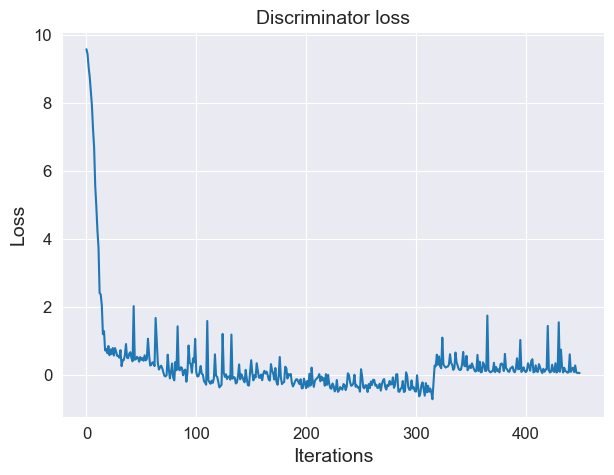

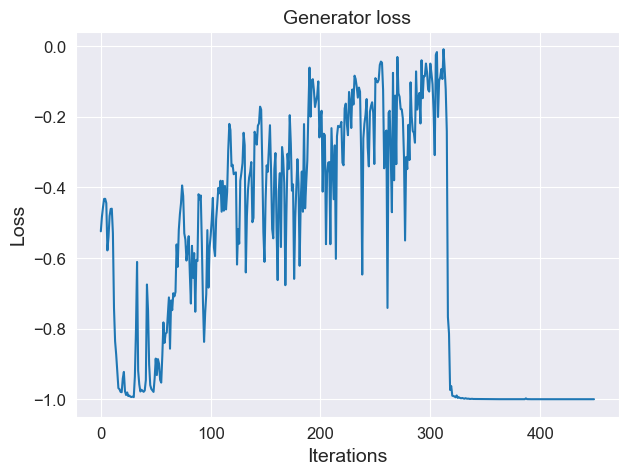


KeyboardInterrupt



In [12]:
# choose these parameters (you have to train the model more than 20 epochs to get good results)
N_CHANNELS = 64   # > 32
N_EPOCHS = 20      # > 10
DISC_STEPS = 2  # > 2
GEN_STEPS = 2
CLIP_C = 1        # < 1
D_lr=D_lr = 3e-5 
G_lr=G_lr = 3e-4  
gp_weight = 5
# ====

generator = Generator(n_channels=N_CHANNELS)
discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)


gen_optimizer = torch.optim.Adam(generator.parameters(), lr=G_lr, betas=(0, 0.9))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_lr, betas=(0, 0.8))

scheduler_G = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=100, gamma=0.96)
scheduler_D = torch.optim.lr_scheduler.StepLR(disc_optimizer, step_size=100, gamma=0.96)

train_losses = train_wgan(
    generator,
    discriminator,
    cifar_train_loader,
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    scheduler_G=scheduler_G,
    scheduler_D=scheduler_D,
    disc_steps=DISC_STEPS,
    gen_steps=GEN_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    use_cuda=USE_CUDA,
    gp_weight=gp_weight,
    plot_frequency=50,
    save_frequency=250,
    init_step=0,
    init_train_losses=None,
)

Не забудьте сохранить обученную модель! Она пригодится в следующем пункте

In [ ]:
# torch.save(generator.state_dict(), '<GEN_PATH>')
# torch.save(discriminator.state_dict(), '<DISC_PATH>')

## Метрики качества (5 pt)

Здесь вам предстоит оценить качество изображений, сгенерированных обученным ранее ГАНом.

In [ ]:
# generator = Generator(n_channels=N_CHANNELS)
# discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)

# generator.load_state_dict(torch.load('<GEN_PATH>'))
# generator.eval()

# discriminator.load_state_dict(torch.load('<DISC_PATH>'))
# discriminator.eval()

### 1. Визуализация распределений (1 pt)

Воспользуйтесь методом, снижающим размерность (TSNE, UMAP, PCA, ...) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи.

Дайте комментарий получившимся результатам

In [78]:
generator = Generator(n_channels=N_CHANNELS).cuda()
generator.load_state_dict(torch.load("checkpoints/generator_step20499.pt", map_location=DEVICE))

<All keys matched successfully>

In [79]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# !pip install umap-learn + from umap import UMAP
from umap import UMAP

real_imgs = []
fake_imgs = []

with torch.no_grad():
    for x, _ in cifar_train_loader:
        real_imgs.extend([el for el in x])
        fake_imgs.extend([el.cpu() for el in generator.sample(x.shape[0])])
        if len(real_imgs) > 5000:
            break

all_images = real_imgs[:5000] + fake_imgs[:5000]

images_converted = UMAP(n_components=2).fit_transform(np.array(all_images).reshape(10000,-1))

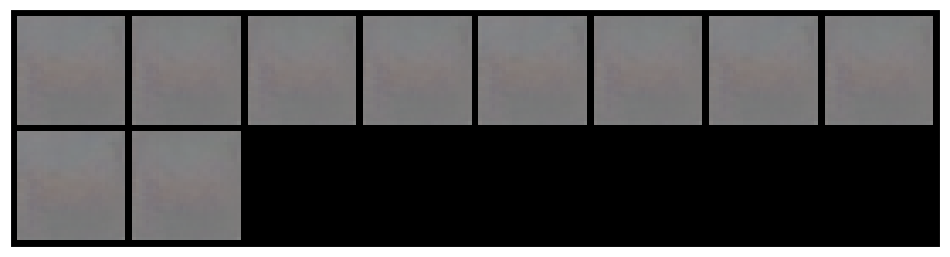

In [80]:
show_images(torch.tensor(np.array(all_images[5000:5010])), torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD))

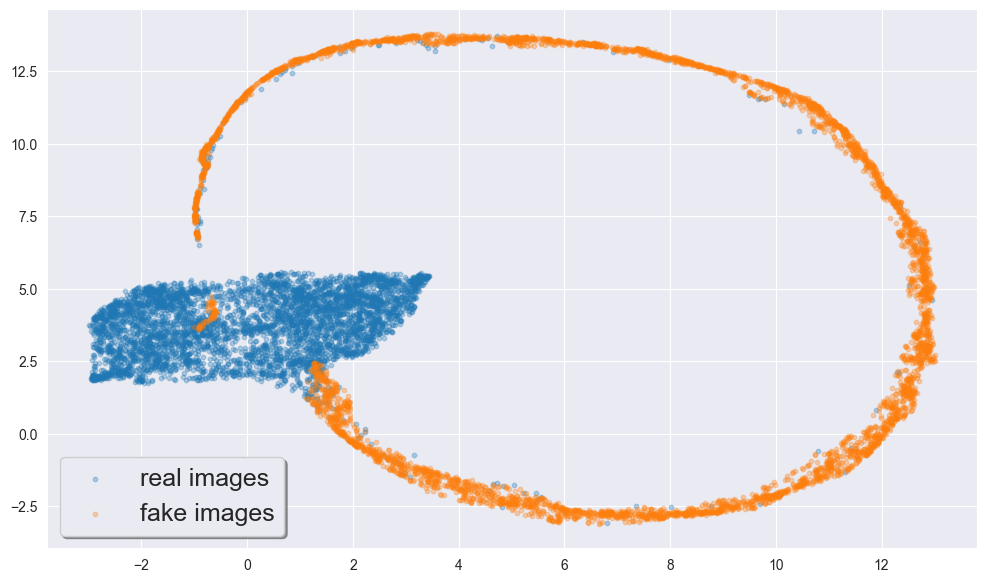

In [89]:
plt.figure(figsize=(12,7))

plt.scatter(images_converted[:5000, 0], images_converted[:5000, 1], 
            alpha=0.3, s=10, label="real images")
plt.scatter(images_converted[5000:, 0], images_converted[5000:, 1], 
            alpha=0.3, s=10, label="fake images")

plt.legend(fontsize=18, shadow=True)
plt.show()

После нескольких десятков попыток оно так и не стало работать нормально, не знаю что здесь комментировать, каждый шаг вроде сделан корректно, графики обучения адекватные. Надо пробовать делать сетку сильно больше, но времени на это уже нет.

### 2. Leave-One-Out 1NN Classifier (2 pt)

Идея подхода такова:
- сгенерировать $n$ фейковых изображений, взять $n$ настоящих из обучающей выборке; присвоить фейковым изображениям класс 0, настоящим – класс 1.
- обучить 1NN Classifier предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет sklearn.model_selection.LeaveOneOut


Каково идеальное значение метрики?
Каким вышел результат вашей модели?

In [110]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_img_per_class = 5000

labels_for_loo = np.array([1] * n_img_per_class + [0] * n_img_per_class)
images_for_loo = np.array(random.sample(all_images[:5000], n_img_per_class) + \
                          random.sample(all_images[5000:], n_img_per_class)).reshape(n_img_per_class*2,-1)
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=12)
loo = LeaveOneOut()

acc = 0

for i, (train_ind, test_ind) in enumerate(tqdm(loo.split(images_for_loo))):
    
    clf.fit(images_for_loo[train_ind], labels_for_loo[train_ind])
    
    pred_label = clf.predict(images_for_loo[test_ind])
    acc += (pred_label.reshape(-1) == labels_for_loo[test_ind])[0]
    
acc /= n_img_per_class * 2
acc

0it [00:00, ?it/s]

0.9851

Идеальное значение метрики в данном случае будет 0.5 (сгенерированные объекты не отличимы от настоящих). Наше, ожидаемо, не идеальное...

### 3. Frechet Inception Distance (FID) (2 pt)

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ вектор среднего и ковариационная матрица признакового представления сэмплов из $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ вектор среднего и ковариационная матрица признакового представления сэмплов из  $p(\mathbf{x} | \boldsymbol{\theta})$.

Для начала реализуем функцию подсчёта расстояния Фреше

In [111]:
# Helper function
def get_matrix_sqrt(x: torch.Tensor) -> torch.Tensor:
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    if not np.isfinite(y).all():
        print("bad!")
    return torch.Tensor(y.real, device=x.device)

In [120]:
def get_distance(
    mu_x: torch.Tensor, mu_y: torch.Tensor, sigma_x: torch.Tensor, sigma_y: torch.Tensor
) -> torch.Tensor:
    ssdiff = (mu_x - mu_y) @ (mu_x - mu_y)
    covmean = get_matrix_sqrt(sigma_x @ sigma_y)

    fid = ssdiff + np.trace(sigma_x + sigma_y - 2.0 * covmean)
    return fid

def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    dist = get_distance(mu_x, mu_y, sigma_x, sigma_y)
    assert np.isclose(dist, 243.7621)


test_get_distance()

Далее реализуем функцию вычисления промежуточных представлений настоящих и сгенерированных изображений

Для генерации признаков воспользуйтесь методом `get_features` из класса `Discriminator`

In [130]:
def get_features(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> tuple:
    if USE_CUDA:
        generator = generator.cuda()
        discriminator.cuda()

    generator.eval()
    discriminator.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples, _ in tqdm(loader):
            if USE_CUDA:
                real_samples = real_samples.cuda()
            # get features of real samples
            real_features = discriminator.get_features(real_samples).cpu()
            
            real_features_list.append(real_features)

            fake_samples = generator.sample(len(real_samples))
            if USE_CUDA:
                fake_samples = fake_samples.cuda()

            # get features of fake samples
            fake_features = discriminator.get_features(fake_samples).cpu()
            
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

Теперь вы готовы реализовать основную функцию подсчёта FID

In [142]:
def get_frechet_inception_distance(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
    max_features=1024,
    # take first 1024 features for each picture, because 16kx16k covariance matrix is failing to calculate
) -> torch.Tensor:
    # 1) get features
    # 2) calculate stats
    # 3) get distance
    fake_features, real_features = get_features(generator,
                                                discriminator,
                                                loader,
                                                n_samples,
                                                batch_size)
   
    mu_x, sigma_x = torch.mean(real_features[:,:max_features], dim=0), torch.cov(real_features[:,:max_features].T)
    mu_y, sigma_y = torch.mean(fake_features[:,:max_features], dim=0), torch.cov(fake_features[:,:max_features].T)

    return get_distance(mu_x, mu_y, sigma_x, sigma_y)

А теперь посчитайте FID на валидационном датасете

In [143]:
N_SAMPLES = 10000

reset_seed()

# generator = Generator(n_channels=N_CHANNELS).cuda()
# generator.load_state_dict(torch.load("checkpoints/generator_step20499.pt", map_location=DEVICE))
# discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C).cuda()
# discriminator.load_state_dict(torch.load("checkpoints/discriminator_step20499.pt", map_location=DEVICE))

fid = get_frechet_inception_distance(
    generator,
    discriminator,
    loader=cifar_val_loader,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
)
print(fid)

  0%|          | 0/105 [00:00<?, ?it/s]

tensor(24.8428)
